In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Cấu hình
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (16, 10)
sns.set_palette("Set2")

print("📂 Đang tải dữ liệu...")
df_events = pd.read_csv('../data/udk_moodle_log.csv')
print(f"✅ Đã tải {len(df_events):,} events")

📂 Đang tải dữ liệu...
✅ Đã tải 1,259,411 events


In [2]:
# Phân loại events: System vs User-driven
SYSTEM_EVENTS = [
    'webservice_function_called',
    'webservice_token_created',
    'user_loggedout',
    'user_loggedin',
    'notification_sent',
    'calendar_event_updated',
    'grade_item_updated'
]

USER_LEARNING_EVENTS = [
    'course_viewed',
    'quiz_attempt_started',
    'quiz_attempt_submitted',
    'assignment_submitted',
    'forum_post_created',
    'resource_viewed',
    'lesson_started',
    'lesson_ended'
]

# Tìm các event name chứa keyword
def classify_event(event_name):
    event_lower = str(event_name).lower()
    
    # System events
    system_keywords = ['webservice', 'token', 'loggedin', 'loggedout', 'notification']
    if any(keyword in event_lower for keyword in system_keywords):
        return 'System Event'
    
    # User learning events
    learning_keywords = ['viewed', 'submitted', 'started', 'created', 'attempt', 'quiz', 'assignment', 'forum']
    if any(keyword in event_lower for keyword in learning_keywords):
        return 'User Learning Event'
    
    return 'Other'

df_events['event_category'] = df_events['eventname'].apply(classify_event)

# Thống kê
category_counts = df_events['event_category'].value_counts()
print("\n📊 Phân loại Events:")
for cat, count in category_counts.items():
    pct = (count / len(df_events)) * 100
    print(f"   {cat}: {count:,} ({pct:.1f}%)")

# Top system events
system_events = df_events[df_events['event_category'] == 'System Event']
print("\n🤖 Top 10 System Events (Nhiễu):")
print(system_events['eventname'].value_counts().head(10))


📊 Phân loại Events:
   User Learning Event: 803,770 (63.8%)
   System Event: 373,173 (29.6%)
   Other: 82,468 (6.5%)

🤖 Top 10 System Events (Nhiễu):
eventname
\core\event\webservice_function_called    288851
\core\event\user_loggedin                  66271
\core\event\user_loggedout                 13590
\core\event\notification_sent               3047
\core\event\notification_viewed              809
\core\event\webservice_token_sent            332
\core\event\webservice_token_created         273
Name: count, dtype: int64



💾 Đang lưu biểu đồ...
✅ Đã lưu: challenge_1_system_noise.png
✅ Đã lưu: challenge_1_system_noise.pdf


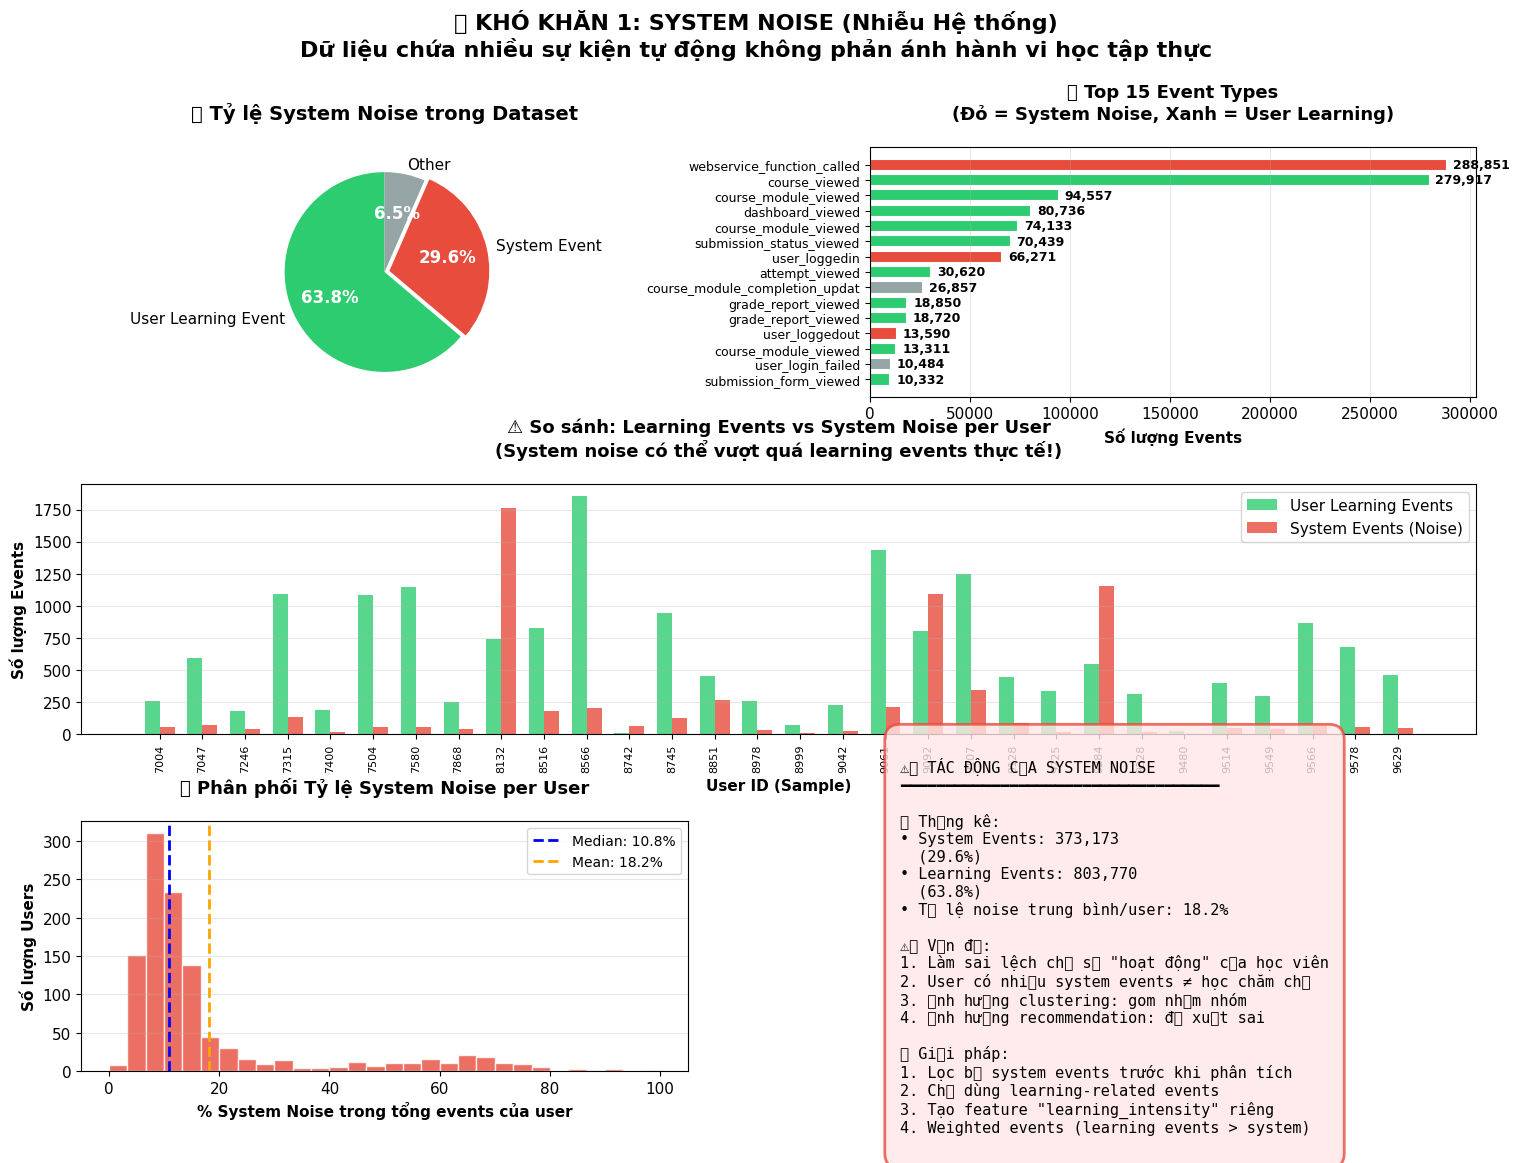


🎉 HOÀN THÀNH! Biểu đồ đã minh họa vấn đề System Noise.


In [3]:
# Tạo biểu đồ minh họa vấn đề System Noise
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# Màu sắc
colors = {
    'System Event': '#e74c3c',        # Đỏ - noise
    'User Learning Event': '#2ecc71', # Xanh - useful
    'Other': '#95a5a6'                # Xám - unknown
}

# ============================================================================
# Panel 1: Pie chart - Tỷ lệ System vs User events
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
wedges, texts, autotexts = ax1.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    colors=[colors[cat] for cat in category_counts.index],
    startangle=90,
    explode=[0.05 if cat == 'System Event' else 0 for cat in category_counts.index]
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)
ax1.set_title('🤖 Tỷ lệ System Noise trong Dataset', fontweight='bold', fontsize=14, pad=20)

# ============================================================================
# Panel 2: Top 15 Event types với màu phân loại
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
top_events = df_events['eventname'].value_counts().head(15)
event_colors = [colors[classify_event(event)] for event in top_events.index]

# Rút gọn tên
event_names_short = [name.split('\\')[-1][:30] for name in top_events.index]
bars = ax2.barh(range(len(top_events)), top_events.values, color=event_colors, edgecolor='white', linewidth=1.5)
ax2.set_yticks(range(len(top_events)))
ax2.set_yticklabels(event_names_short, fontsize=9)
ax2.set_xlabel('Số lượng Events', fontweight='bold', fontsize=11)
ax2.set_title('📊 Top 15 Event Types\n(Đỏ = System Noise, Xanh = User Learning)', 
              fontweight='bold', fontsize=13, pad=20)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Thêm giá trị
for i, (bar, val) in enumerate(zip(bars, top_events.values)):
    ax2.text(val + max(top_events.values)*0.01, i, f'{val:,}', 
             va='center', fontsize=9, fontweight='bold')

# ============================================================================
# Panel 3: So sánh user activity với/không system events
# ============================================================================
ax3 = fig.add_subplot(gs[1, :])

# Tính số events per user
user_all_events = df_events.groupby('userid').size()
user_learning_events = df_events[df_events['event_category'] == 'User Learning Event'].groupby('userid').size()
user_system_events = df_events[df_events['event_category'] == 'System Event'].groupby('userid').size()

# Reindex để match
user_learning_events = user_learning_events.reindex(user_all_events.index, fill_value=0)
user_system_events = user_system_events.reindex(user_all_events.index, fill_value=0)

# Lấy sample 50 users ngẫu nhiên để dễ nhìn
sample_users = np.random.choice(user_all_events.index, size=min(50, len(user_all_events)), replace=False)
sample_users = sorted(sample_users)[:30]  # Top 30 để đẹp

x = np.arange(len(sample_users))
width = 0.35

bars1 = ax3.bar(x - width/2, user_learning_events[sample_users], width, 
                label='User Learning Events', color=colors['User Learning Event'], alpha=0.8)
bars2 = ax3.bar(x + width/2, user_system_events[sample_users], width,
                label='System Events (Noise)', color=colors['System Event'], alpha=0.8)

ax3.set_xlabel('User ID (Sample)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Số lượng Events', fontweight='bold', fontsize=11)
ax3.set_title('⚠️ So sánh: Learning Events vs System Noise per User\n(System noise có thể vượt quá learning events thực tế!)', 
              fontweight='bold', fontsize=13, pad=20)
ax3.set_xticks(x)
ax3.set_xticklabels(sample_users, rotation=90, fontsize=8)
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3)

# ============================================================================
# Panel 4: Histogram - Phân phối tỷ lệ system noise per user
# ============================================================================
ax4 = fig.add_subplot(gs[2, 0])
user_noise_ratio = (user_system_events / user_all_events * 100).fillna(0)

ax4.hist(user_noise_ratio, bins=30, color=colors['System Event'], edgecolor='white', alpha=0.8)
ax4.axvline(user_noise_ratio.median(), color='blue', linestyle='--', linewidth=2, 
            label=f'Median: {user_noise_ratio.median():.1f}%')
ax4.axvline(user_noise_ratio.mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Mean: {user_noise_ratio.mean():.1f}%')
ax4.set_xlabel('% System Noise trong tổng events của user', fontweight='bold', fontsize=11)
ax4.set_ylabel('Số lượng Users', fontweight='bold', fontsize=11)
ax4.set_title('📈 Phân phối Tỷ lệ System Noise per User', fontweight='bold', fontsize=13, pad=20)
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)

# ============================================================================
# Panel 5: Text box - Tác động và giải pháp
# ============================================================================
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

impact_text = f"""
⚠️ TÁC ĐỘNG CỦA SYSTEM NOISE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Thống kê:
• System Events: {category_counts.get('System Event', 0):,} 
  ({category_counts.get('System Event', 0)/len(df_events)*100:.1f}%)
• Learning Events: {category_counts.get('User Learning Event', 0):,}
  ({category_counts.get('User Learning Event', 0)/len(df_events)*100:.1f}%)
• Tỷ lệ noise trung bình/user: {user_noise_ratio.mean():.1f}%

⚠️ Vấn đề:
1. Làm sai lệch chỉ số "hoạt động" của học viên
2. User có nhiều system events ≠ học chăm chỉ
3. Ảnh hưởng clustering: gom nhầm nhóm
4. Ảnh hưởng recommendation: đề xuất sai

✅ Giải pháp:
1. Lọc bỏ system events trước khi phân tích
2. Chỉ dùng learning-related events
3. Tạo feature "learning_intensity" riêng
4. Weighted events (learning events > system)
"""

ax5.text(0.05, 0.5, impact_text, fontsize=11, family='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor='#ffe6e6', alpha=0.8, edgecolor='#e74c3c', linewidth=2),
         verticalalignment='center')

# ============================================================================
# Tiêu đề chính
# ============================================================================
fig.suptitle('🚨 KHÓ KHĂN 1: SYSTEM NOISE (Nhiễu Hệ thống)\nDữ liệu chứa nhiều sự kiện tự động không phản ánh hành vi học tập thực', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()

# Lưu file
print("\n💾 Đang lưu biểu đồ...")
plt.savefig('challenge_1_system_noise.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Đã lưu: challenge_1_system_noise.png")

plt.savefig('challenge_1_system_noise.pdf', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Đã lưu: challenge_1_system_noise.pdf")

plt.show()

print("\n🎉 HOÀN THÀNH! Biểu đồ đã minh họa vấn đề System Noise.")

## Kết luận

Biểu đồ trên cho thấy:

1. **Tỷ lệ system noise** chiếm một phần đáng kể trong dataset
2. **So sánh trực tiếp** giữa learning events và system events cho từng user
3. **Phân phối noise** khác nhau giữa các users
4. **Tác động** và **giải pháp** cụ thể để xử lý vấn đề này

Đây là một trong những khó khăn chính cần giải quyết trước khi áp dụng clustering và Q-learning.